In [1]:
# Mount Google Drive to access data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pickle
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn import svm

In [32]:
# Initialization params

nClusters = 800
svm_c = 0.01
svm_gamma = 0.01
svm_kernal = 'rbf'

datasetPath = '/content/drive/MyDrive/cifar10/cifar-10-batches-py'
vocabFile = 'vocab_800.sav'
clsFile = 'cls.sav'
trainBatch = 1
'''trainImgPerBatch = 50
testImgPerBatch = 50'''

'trainImgPerBatch = 50\ntestImgPerBatch = 50'

In [4]:
# For returning the corresponding label

def getLabel(id):
    txtLabels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    return txtLabels[id]

In [5]:
# Load Batch data

def loadBatch(filePath):
    with open(filePath, 'rb') as fo:
        batchDict = pickle.load(fo, encoding='latin1')
        nImgs = len(batchDict['data'])
        imgs = batchDict['data'].reshape(nImgs,3,32,32).transpose(0, 2, 3, 1)
        labels = batchDict['labels']
    return (imgs,labels)

In [6]:
# Get Descriptors from here

def getDescriptors(img, extractor):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    keypoints, descriptors = extractor.detectAndCompute(gray, None)
    return descriptors

In [7]:
# Get descriptors for Batch Data
def getBatchDesc(imgs):
    descriptors = np.asarray([])
    extractor = cv2.xfeatures2d.SIFT_create()
    #i = 0
    for img in imgs:
        desc = getDescriptors(img,extractor)
        if type(desc) == np.ndarray :
            if descriptors.shape[0] == 0:
                descriptors = desc
            else:
                descriptors = np.concatenate((descriptors, desc), axis=0)
    return descriptors

In [8]:
# Get descriptors for dataset
def getDatasetDesc():
    descriptors = np.asarray([])
    for batchId in range(1,trainBatch+1):
        batchPath = datasetPath+'/'+'data_batch_'+str(batchId)
        imgs,labels = loadBatch(batchPath)
        if descriptors.shape[0] == 0:
            descriptors = getBatchDesc(imgs)
        else:
            descriptors = np.concatenate((descriptors, getBatchDesc(imgs)), axis=0)
    return descriptors

In [9]:
# Get Visual Vocabularies
def getVocabularies():
    descriptors = getDatasetDesc()
    kmeans = KMeans(n_clusters = nClusters)
    kmeans.fit(descriptors)
    return kmeans

In [10]:
# Function to get bag of keypoints for a single image
def getBagOfKP(img,extractor,vocab):
    bok = [0]*nClusters
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    keypoints, descriptors = extractor.detectAndCompute(gray, None)
    if type(descriptors) == np.ndarray:
        pred = vocab.predict(descriptors)
        for ele in pred:
            bok[ele] = bok[ele] + 1
    return bok

In [11]:
# Function to get bag of keypoints for a batch of images
def getBatchBOK(imgs,vocab):
    batchBOK = []
    extractor = cv2.xfeatures2d.SIFT_create()
    for img in imgs:
        bok = getBagOfKP(img,extractor,vocab)
        batchBOK.append(bok)
    return  np.asarray(batchBOK)

In [12]:
# Get train features and labels
def getTrainingDT(vocab):
    dataset = np.asarray([])
    labels = []
    for batchId in range(1,trainBatch+1):
        print('collecting batch ',str(batchId),' features ...')
        batchPath = datasetPath+'/'+'data_batch_'+str(batchId)
        imgs,labs = loadBatch(batchPath)
        if dataset.shape[0] == 0:
            dataset = getBatchBOK(imgs,vocab)
            labels = labs
        else:
            dataset = np.concatenate((dataset, getBatchBOK(imgs,vocab)), axis=0)
            labels.extend(labs)
    return (dataset,np.asarray(labels))

In [13]:
# Get test features and labels
def getTestingDT(vocab):
    batchPath = datasetPath+'/test_batch'
    imgs,labels = loadBatch(batchPath)
    dataset = getBatchBOK(imgs,vocab)
    return (dataset,np.asarray(labels))

In [14]:
vocab = getVocabularies()
pickle.dump(vocab, open(vocabFile, 'wb'))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [15]:
# Getting Train data and labels
dataset,labels = getTrainingDT(vocab)

collecting batch  1  features ...


In [33]:
model = svm.SVC(kernel=svm_kernal)
print("training started...")
model.fit(dataset,labels)
pickle.dump(model, open(clsFile, 'wb'))

training started...


In [34]:
# Getting Test data and labels
testDt,testLb = getTestingDT(vocab)

In [35]:
acc = model.score(testDt,testLb)

In [36]:
print("Accuracy for SVM model")
print(acc)

Accuracy for SVM model
0.2767


In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [38]:
# Using KNN and Logistic Regression

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(dataset,labels)
accuracy_knn = knn.score(testDt,testLb)
print("Accuracy for KNN model")
print(accuracy_knn)
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(dataset,labels)
accuracy_log_reg = log_reg.score(testDt,testLb)
print("Accuracy for Logistic Regression model")
print(accuracy_log_reg)

Accuracy for KNN model
0.1195
Accuracy for Logistic Regression model
0.2502


In [39]:
from sklearn.metrics import confusion_matrix, classification_report
# Predictions
predictions = model.predict(testDt)

# Confusion matrix
conf_matrix = confusion_matrix(testLb, predictions)

# Classification report
class_report = classification_report(testLb, predictions)

Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.36      0.37      1000
           1       0.38      0.33      0.35      1000
           2       0.22      0.25      0.24      1000
           3       0.19      0.18      0.19      1000
           4       0.19      0.15      0.17      1000
           5       0.24      0.24      0.24      1000
           6       0.24      0.22      0.23      1000
           7       0.30      0.32      0.31      1000
           8       0.33      0.39      0.36      1000
           9       0.29      0.33      0.31      1000

    accuracy                           0.28     10000
   macro avg       0.27      0.28      0.27     10000
weighted avg       0.27      0.28      0.27     10000



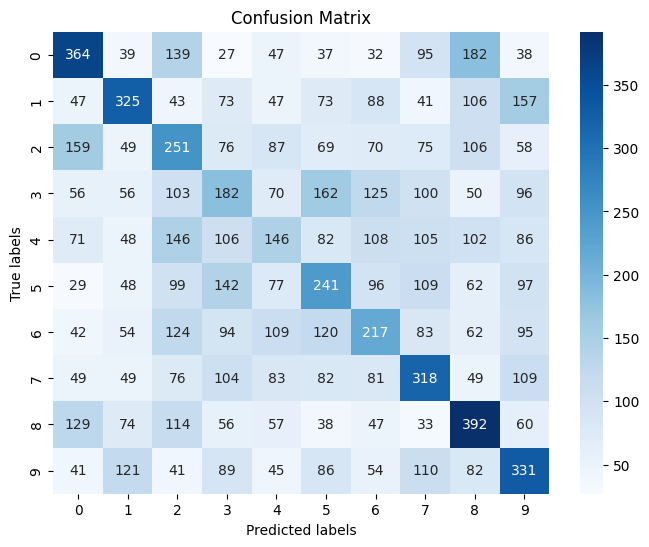

In [40]:
import seaborn as sns
print("Classification Report:")
print(class_report)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()